### GSS with adaptVQE for Heisenberg Hamiltonian
Main changes:
- calc_gradients function for operator pool gradients runs faster (changed order of computation)
- comparison for different truncations added (similar to PP (Classically estim. obs...)paper)

Future improvements:
- ForwardDiff gradient calculation for operator pool (actual gradient of truncated evolution, not the physically correct formula(BCH))

- SPSA-ADAM optimizer, which only needs 2 function evaluations per gradient calculation (same as in HVA paper - GSS with PP) --> if this works great, we can skip the next 2 steps
- use Mooncake backend and thus min_abs_coeff truncations as opposed to max_freq (max freq is only justified for small parameters, due to accumulated sign terms, here we are not in the small angle regime)
- have a Base.Threads option, which paralellizes the for loop on CPU cores (either RD or Mooncake)
- ThreadsX parallelisation in the lossfunction (term wise propagation of H)

In [1]:
using PauliPropagation
using Plots
using ReverseDiff
using ReverseDiff: GradientTape, gradient!, compile, gradient
using Bits
using Random
using Distributions: Uniform
using NLopt
import ForwardDiff

### 0) System and Initial State Construction

In [2]:
# Heisenberg Hamiltonian ready to be used in lossfunctions
# keep topology as main argument to avoid forgetting it
function heisenberg_hamiltonian(::Type{CT}, nq::Int, topology; J=1.0) where CT
    
    psum = PauliSum(CT,nq)
    Jc = convert(CT, J)
    if isnothing(topology)
        topology = bricklayertopology(nq;periodic=false) #chain with obc
    end

    for pair in topology
        add!(psum, [:X,:X], collect(pair), Jc)
        add!(psum, [:Y,:Y], collect(pair), Jc)
        add!(psum, [:Z,:Z], collect(pair), Jc)
    end
    return psum
end
# add type default
heisenberg_hamiltonian(nq::Int, topology; J=1.0) = heisenberg_hamiltonian(Float64, nq, topology; J=J)

heisenberg_hamiltonian (generic function with 2 methods)

In [3]:
nq = 3
topology = bricklayertopology(nq;periodic=false)
heisenberg_hamiltonian(nq, topology; J=1.0)

PauliSum(nqubits: 3, 6 Pauli terms:
 1.0 * XXI
 1.0 * ZZI
 1.0 * IXX
 1.0 * YYI
 1.0 * IZZ
 1.0 * IYY
)

In [4]:
function neel_bits(nq::Int; up_on_odd::Bool=true)
    if up_on_odd
        # |0101...> → "1" on even sites
        return collect(2:2:nq)
    else
        # |1010...> → "1" on odd sites
        return collect(1:2:nq)
    end
end

neel_bits (generic function with 1 method)

In [5]:
@time grads = calc_gradients_phys(generate_full_bit_pool(nq), heisenberg_hamiltonian(nq, topology; J=1.0), nq; verbose=false)

UndefVarError: UndefVarError: `generate_full_bit_pool` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [6]:
# example usage:
neel_bits(10; up_on_odd=true)

5-element Vector{Int64}:
  2
  4
  6
  8
 10

In [7]:
# customized overlap function
# since we are in the Heisenberg picture, we propagate observables and in the final step, calculate the overlap with the initial state
function overlapwithneel(operator, nq::Int; 
                           up_on_odd::Bool=true, 
                           params=nothing)
                           
    # Create Néel state bit representation: indices of "1" bits
    nb = neel_bits(nq; up_on_odd=up_on_odd)
    
    # Compute overlap with computational basis state
    return overlapwithcomputational(operator, nb)
end

overlapwithneel (generic function with 1 method)

### 1) Full Operator Pool (Hamiltonian-Independent)

In [8]:
function generate_full_bit_pool(nq::Int)
    # Choose appropriate UInt type based on number of qubits (same as PP does)
    # Work with bit representations directly (easier to manipulate)
    UIntType = if nq <= 4
        UInt8
    elseif nq <= 8
        UInt16
    elseif nq <= 16
        UInt32
    else
        UInt64
    end
    
    # Here, we generate all non-identity bit patterns (therefore -1), which gives the full operator pool.
    pool = UIntType[]
    for i in 1:(4^nq - 1)
        push!(pool, UIntType(i))
    end
    
    return pool
end

generate_full_bit_pool (generic function with 1 method)

In [9]:
# Function to convert bit representation to PauliString when needed
function bit_to_paulistring(bit_repr, nq)
    paulis = Symbol[]
    sites = Int[]
    
    for qubit in 1:nq #going from right to left in bitstring
        pauli_val = getpauli(bit_repr, qubit) # get pauli of qubit as 0,1,2,3
        #println("Qubit $qubit: Pauli value = $pauli_val")
        if pauli_val != 0  # Skip identity (0) since Paulis are initialised as identity by default
            pauli_symbol = [:I, :X, :Y, :Z][pauli_val + 1] # julia indexing starts at 1!
            push!(paulis, pauli_symbol)
            push!(sites, qubit)
        end
    end
    
    return PauliString(nq, paulis, sites, 1.0), paulis, sites
end

bit_to_paulistring (generic function with 1 method)

### 2) AdaptVQE Elements and Tests

In [10]:
"""
    calc_gradients(bit_pool, H, nq;
                   circuit=nothing, params=nothing,
                   tol=1e-12, verbose=false, up_on_odd=true)

ADAPT-VQE gradients with in-place propagation:
g_P = ⟨φ₀ | [U† H U, U† P U] i | φ₀⟩, where |φ₀⟩ is the Néel state
selected by `up_on_odd`.
"""
function calc_gradients(bit_pool, H, nq;
                        circuit::Union{Nothing,Any}=nothing,
                        params::Union{Nothing,AbstractVector}=nothing,
                        tol::Float64=1e-12,
                        verbose::Bool=false,
                        up_on_odd::Bool=true)

    grads = Float64[]

    # Pre-propagate H once: H_prop = U† H U (only if a circuit is provided)
    H_prop = H
    if circuit !== nothing
        H_prop = deepcopy(H)                 # avoid mutating H
        propagate!(circuit, H_prop, params)  # in-place propagation
    end

    # For each pool element, pre-propagate P (to P_prop) and form [H_prop, P_prop]
    for (k, bit_repr) in enumerate(bit_pool)
        P= bit_to_paulistring(bit_repr, nq)[1]
        psum = PauliSum(nq)
        P = add!(psum, P) # PP works with PauliSums (see datatypes example notebook)

        P_prop = P
        if circuit !== nothing
            P_prop = deepcopy(P)                 # avoid mutating the pool op
            propagate!(circuit, P_prop, params)  # in-place propagation
        end
        
        C = commutator(H_prop, P_prop) 
        if !(iterate(C) !== nothing)           # if the commutator is empty 
            verbose && println("op[$k]: ", P, "  commutator=0  → grad=0.0")
            push!(grads, 0.0)
            continue
        end
        g = overlapwithneel(im * C, nq; up_on_odd=up_on_odd)
        if abs(imag(g)) > tol
            @warn "Gradient has non-negligible imaginary part" imag=imag(g) op=P
        end

        push!(grads, real(g))
        verbose && println("op[$k]: ", P, "  grad=", real(g))
    end

    return grads
end

calc_gradients

In [11]:
# an equivalent formulation with the commutator, with slight reordering of terms (time benchmark to do)
"""
    calc_gradients_phys(bit_pool, H, nq;
                   circuit=nothing, params=nothing,
                   tol=1e-12, verbose=false, up_on_odd=true)

ADAPT-VQE gradients with in-place propagation:
g_P = i * ⟨φ₀ | U_ansatz† [H, P] U_ansatz | φ₀⟩, where |φ₀⟩ is the Néel state
selected by `up_on_odd`.
"""
function calc_gradients_phys(bit_pool, H, nq;
                        circuit::Union{Nothing,Any}=nothing,
                        params::Union{Nothing,AbstractVector}=nothing,
                        tol::Float64=1e-12,
                        verbose::Bool=false,
                        up_on_odd::Bool=true)

    grads = Float64[]

    for (k, bit_repr) in enumerate(bit_pool)
        P_op, _, _ = bit_to_paulistring(bit_repr, nq)
        P = PauliSum(nq)
        add!(P, P_op)

        # Calculate the commutator with the original Hamiltonian
        C = commutator(H, P)

        if !(iterate(C) !== nothing) # if the commutator is empty
            verbose && println("op[$k]: ", P, "  commutator=0  → grad=0.0")
            push!(grads, 0.0)
            continue
        end

        # Propagate the commutator through the circuit if it exists
        C_prop = C
        if circuit !== nothing
            C_prop = deepcopy(C)
            propagate!(circuit, C_prop, params)
        end

        # Calculate the gradient as the expectation value of the propagated commutator
        g = overlapwithneel(im * C_prop, nq; up_on_odd=up_on_odd)

        if abs(imag(g)) > tol
            @warn "Gradient has non-negligible imaginary part" imag=imag(g) op=P
        end

        push!(grads, real(g))
        verbose && println("op[$k]: ", P, "  grad=", real(g))
    end

    return grads
end

calc_gradients_phys

In [12]:
# example usage
topo = bricklayertopology(nq;periodic=false)
grads = calc_gradients_phys(generate_full_bit_pool(nq), heisenberg_hamiltonian(nq, topo), nq; verbose=false, up_on_odd=true)

63-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
 -4.0
  0.0
  0.0
  4.0
  0.0
  ⋮
  0.0
  0.0
  4.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [13]:
function pick_top_operator(gradients::AbstractVector, operators::AbstractVector; rng=Random.GLOBAL_RNG)
    length(gradients) == length(operators) || throw(ArgumentError("gradients and operators must have same length"))
    isempty(gradients) && throw(ArgumentError("gradients must not be empty"))
    
    mags = abs.(gradients)
    order = sortperm(mags, rev=true)  # indices sorted by |grad| descending (following the nature paper implementation)
    gradients_sorted = gradients[order]
    operators_sorted = operators[order]

    max_mag = mags[order[1]]
    tied_top = filter(i -> mags[i] == max_mag, order)

    chosen_idx = rand(rng, tied_top)

    return operators[chosen_idx], gradients[chosen_idx], gradients_sorted, operators_sorted
end

pick_top_operator (generic function with 1 method)

In [14]:
# example usage:
top_op, top_grad, grads_sorted, ops_sorted = pick_top_operator(grads, generate_full_bit_pool(nq))
println("Top operator: ", bit_to_paulistring(top_op,nq)[1], " with gradient ", top_grad)
println("Top gradient: ", grads_sorted) # we ignore the signs when sorting

Top operator: PauliString(nqubits: 3, 1.0 * YXI) with gradient -4.0
Top gradient: [-4.0, 4.0, 4.0, 4.0, -4.0, -4.0, -4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [15]:
function check_convergence(gradients; tol=1e-4)
    max_grad = maximum(abs.(gradients))
    return max_grad < tol, max_grad
end

check_convergence (generic function with 1 method)

In [16]:
# example usage:
check_convergence(grads; tol=1e-4)

(false, 4.0)

In [17]:
function pauli_rotation_from_bits(bit_repr, nq)
    _, paulis, sites = bit_to_paulistring(bit_repr, nq) 
    return PauliRotation(paulis, sites)
end

pauli_rotation_from_bits (generic function with 1 method)

In [18]:
# example usage:
pauli_rotation_from_bits(top_op,nq)

PauliRotation([:Y, :X], [1, 2])

In [19]:
function append_from_bits!(circuit, thetas, chose_op, nq; theta_init=rand())
    gate = pauli_rotation_from_bits(chose_op, nq)
    push!(circuit, gate) # not pushfirst! since we want to apply new gate last (Schrödinger!!)
    push!(thetas, theta_init) # we warm-start the parameters of the new circuit (reusing thetas)
    return circuit, thetas    # index of the new parameter
end

append_from_bits! (generic function with 1 method)

In [20]:
# example usage:
circuit = Any[]      # initialize the adaptVQE circuit
thetas  = Float64[]  # initialize the parameter list
circuit, thetas = append_from_bits!(circuit,thetas,top_op,nq; theta_init = 0.2)

(Any[PauliRotation([:Y, :X], [1, 2])], [0.2])

### 3) Loss functions and Closures
If we use L-BFGS optimizer, we have several options:
- DONE: ReverseDiff lossfunction (with frequency tracker - as previously done)
- Mooncake lossfunction (with min_abs_coeff, this makes more sense since the max_freq truncation is justified for small angles only), small coefficients just contribute less to the final expectation value

For both versions, we can either thread the for-loop of the full loss function or not. (TODO: compare runtimes for high enough load)

There is also the alternative to use the ThreadsX package for more highlevel (further optimized) threading. This needs to be inbuilt in the optimizer.

Alternatively, we can avoid the AD gradient calculation by using the SPSA-ADAM optimizer.

Here, I'll put the SPSA-ADAM and an L-BFGS with ReverseDiff (no threading).
The optimizer is chosen in the target_optimization function.

In [21]:
function fulllossfunction(thetas, circuit, nq;topology = nothing, max_freq = Inf, max_weight = Inf)

    if isnothing(topology)
        topology = bricklayertopology(nq;periodic=false) #chain with obc
    end

    # differentiation libraries use custom types to trace through the computation
    # we need to make all of our objects typed like that so that nothing breaks
    CoeffType = eltype(thetas)

    H = PauliSum(CoeffType, nq)

    for pair in topology
        add!(H, [:X,:X], collect(pair),CoeffType(1.0))
        add!(H, [:Y,:Y], collect(pair),CoeffType(1.0))
        add!(H, [:Z,:Z], collect(pair),CoeffType(1.0))
    end

    # wrap the coefficients into PauliFreqTracker so that we can use `max_freq` truncation.
    # usually this happens automatically but the in-place propagate!() function does not allow that.
    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    
    # we also need to run the in-place version with `!`, because by default we copy the Pauli sum
    output_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);
    return overlapwithneel(output_H,nq)
end

fulllossfunction (generic function with 1 method)

In [22]:
function adam_optimizer(thetas_init, lossfun, nq; eta=0.02, steps=150, refresh_grad_tape=10)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    grad = similar(thetas_init)
    thetas = copy(thetas_init)
    opt_energy = Float64[]

    m = zero(thetas)
    v = zero(thetas)
    β1, β2, ϵ = 0.9, 0.999, 1e-8

    for t in 1:steps

        if t%refresh_grad_tape == 0 # refresh the tape to avoid wrong gradients
                tape = GradientTape(lossfun, thetas)
                compile(tape)
        end
        gradient!(grad, tape, thetas)
        m .= β1 .* m .+ (1 - β1) .* grad
        v .= β2 .* v .+ (1 - β2) .* (grad .^ 2)
        m̂ = m ./ (1 - β1^t)
        v̂ = v ./ (1 - β2^t)
        thetas .-= eta .* m̂ ./ (sqrt.(v̂) .+ ϵ)
        push!(opt_energy, lossfun(thetas) / nq)
    end
    return thetas, opt_energy
end


adam_optimizer (generic function with 1 method)

In [23]:
function lbfgs_optimizer(thetas_init, lossfun, nq; max_iters=300, refresh_grad_tape=10)
    n = length(thetas_init)
    tape_ref = Ref(GradientTape(lossfun, thetas_init)) # Ref is only necessary in the LBFGS case because the closure otherwise can’t update an outer variable that NLopt is still using.
    compile(tape_ref[])
    gradbuf = zeros(n)
    iter_ref = Ref(0)
    opt = NLopt.Opt(:LD_LBFGS, n)
    NLopt.maxeval!(opt, max_iters)

    opt_energy = Float64[]
    NLopt.min_objective!(opt, (x, grad) -> begin

        iter_ref[] += 1
        # Re-record the tape every `refresh_grad_tape` evaluations
        # record with the current x so shapes/aliasing match
        if refresh_grad_tape > 0 && (iter_ref[] % refresh_grad_tape == 0)
            tape_ref[] = GradientTape(lossfun, x)
            compile(tape_ref[])
        end

        fx = lossfun(x)::Float64
        if !isempty(grad)
            gradient!(gradbuf, tape_ref[], x)
            grad .= gradbuf
        end
        push!(opt_energy, fx)
        return fx
    end)
    minf, thetas, ret = NLopt.optimize(opt, thetas_init)
    return thetas, opt_energy ./ nq
end


lbfgs_optimizer (generic function with 1 method)

In [24]:
function target_optimization(nq, circuit, thetas; max_freq=Inf, max_weight=Inf, verbose = false, refresh_grad_tape=10)
    # again, automatic diff example notebook for more details
    closed_lossfunction = let const_nq=nq, const_max_freq=max_freq, const_max_weight=max_weight
        # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
        # See also "closures"
        theta -> fulllossfunction(theta, circuit, const_nq; max_freq=const_max_freq, max_weight=const_max_weight)
    end
    
    #opt_thetas, opt_energy_gd = adam_optimizer(thetas,closed_lossfunction,nq)
    opt_thetas,opt_energy_gd = lbfgs_optimizer(thetas,closed_lossfunction,nq;refresh_grad_tape=refresh_grad_tape)
    if verbose
        println("Optimized thetas: ", opt_thetas)
        println("Optimized energy per qubit: ", opt_energy_gd[end])

        plot(opt_energy_gd)
        display(plot!(title = "Energy optimisation", xlabel = "runs", ylabel = "E/Q"))
    end

    return opt_thetas, opt_energy_gd
end

target_optimization (generic function with 1 method)

### 4) AdaptVQE Loop

In [25]:
function adaptVQE_loop(nq, hamiltonian, bit_pool; theta_init = rand(Uniform(-π, π)), max_iters=10, max_freq=Inf, max_weight=Inf, conv_tol=1e-4, refresh_grad_tape=10, verbose=true)
    circuit = Any[]      # initialize the adaptVQE circuit
    thetas  = Float64[]; # initialize the parameter list
    energy_per_loop = Float64[];
    max_grads = Float64[] # collect for analysis
    chosen_ops = UInt[]

    for iter in 1:max_iters

        # 1) Calculate gradients
     
        grads = calc_gradients_phys(bit_pool, hamiltonian, nq; circuit=circuit, params=thetas, tol=1e-12, verbose=false, up_on_odd=true)

        # 2) Check convergence
        converged, max_grad = check_convergence(grads; tol=conv_tol)
        push!(max_grads, max_grad)
        
        if converged
            println("Convergence achieved with max gradient < $conv_tol")
            break
        end

        # 3) Pick top operator
        chose_op, grad_op, grads_sorted, _ = pick_top_operator(grads, bit_pool)

        push!(chosen_ops, chose_op)

        # 4) Append operator to circuit
        circuit, thetas = append_from_bits!(circuit, thetas, chose_op, nq; theta_init=theta_init) 

        # 5) Optimize parameters

        thetas, opt_energy_gd = target_optimization(nq, circuit, thetas; max_freq=max_freq, max_weight=max_weight,verbose=false, refresh_grad_tape=refresh_grad_tape)
    
        
        # wrap the thetas to [-π,π] since they are angles
        thetas = rem2pi.(thetas,RoundNearest) # does not seem to help the optimization
        push!(energy_per_loop, opt_energy_gd[end])
    end

    # 6) Plot the gradient convergence
    if verbose
        plot(max_grads, marker=:o)
        display(plot!(title = "Max Gradient Convergence", xlabel = "Iteration", ylabel = "Max Gradient"))
    end

    return circuit, thetas, chosen_ops, energy_per_loop, max_grads
end

adaptVQE_loop (generic function with 1 method)

### Small Full Pool Run

In [26]:
# we can run without truncations for small full pool
nq = 3
topo = bricklayertopology(nq;periodic=false)
hamiltonian = heisenberg_hamiltonian(nq, topo)
full_bit_pool = generate_full_bit_pool(nq)
circuit, thetas, chosen_ops, energy_per_loop, max_grads = adaptVQE_loop(nq, hamiltonian, full_bit_pool;theta_init = rand(Uniform(-0.1,0.1)), max_iters=25, conv_tol=1e-4, verbose=false);

Convergence achieved with max gradient < 0.0001


In [27]:
println("size of full bit pool: ", size(full_bit_pool))

size of full bit pool: (63,)


In [28]:
println("Final thetas: ", thetas)

Final thetas: [1.1071487184047475, -0.7297276571981145, 0.4636476083896691]


In [29]:
energy_per_loop # -1.333 is the ED result for 3 qubits, -1.6160254 ED for 4 qubits, -1.54230900265439 for 5 qubits.

3-element Vector{Float64}:
 -1.0786893258332633
 -1.2761423749153966
 -1.3333333333333333

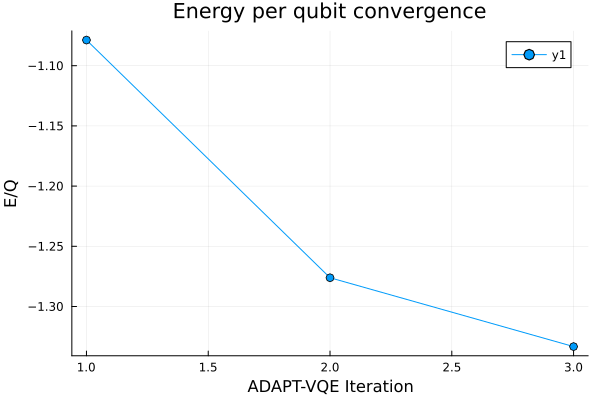

In [30]:
plot(energy_per_loop, marker=:o)
plot!(title = "Energy per qubit convergence", xlabel = "ADAPT-VQE Iteration", ylabel = "E/Q")

### 5) Tiles Approach

In [31]:
function scaled_pool_selection(nq, hamiltonian, full_bit_pool; num_runs=5, run_iters=5, conv_tol=1e-4, refresh_grad_tape=10, verbose=false)
    all_chosen_ops = UInt[]
    for run in 1:num_runs
        #println("=== ADAPT-VQE Run $run ===")
        circuit, thetas, chosen_ops = adaptVQE_loop(nq, hamiltonian, full_bit_pool; max_iters=run_iters, conv_tol=conv_tol, verbose=verbose, refresh_grad_tape=refresh_grad_tape)
        append!(all_chosen_ops, chosen_ops)
    end
    return unique(all_chosen_ops)  # Return unique operators from all runs
end


function scaled_pool_generation(tile_nq, scaled_nq,hamiltonian, full_bit_pool; num_runs=5, run_iters=5, conv_tol=1e-4, refresh_grad_tape=10, verbose=false)
    #Choose appropriate UInt type based on number of qubits (same as PP does)
        UIntType = if scaled_nq <= 4
            UInt8
        elseif scaled_nq <= 8
            UInt16
        elseif scaled_nq <= 16
            UInt32
        else
            UInt64
        end

        chosen_ops = scaled_pool_selection(tile_nq, hamiltonian, full_bit_pool; num_runs=num_runs, run_iters=run_iters, conv_tol=conv_tol, refresh_grad_tape=refresh_grad_tape, verbose=verbose)
        println("Chosen operators from tile ADAPT-VQE: ", length(chosen_ops))
        scaled_pool = UIntType[]
        for op in chosen_ops
            ps, paulis, sites = bit_to_paulistring(op, tile_nq) 
            weight = length(paulis)
            # Preserve the operator's internal geometry: compute zero-based relative offsets
            min_site = minimum(sites)
            rel_sites = sites .- min_site
            block_span = maximum(rel_sites) + 1 # equivalent to block_span = maximum(sites) - minimum(sites) + 
        # Slide the block from left to right without wrapping (open boundaries)
        for start in 1:(scaled_nq - block_span + 1)
            new_sites = start .+ rel_sites  # keep internal offsets
            new_op = PauliString(scaled_nq, paulis, collect(new_sites), 1.0)
            push!(scaled_pool, (new_op.term))
        end
    end
    return unique(scaled_pool)
end

scaled_pool_generation (generic function with 1 method)

### Run AdaptVQE with new Pool

In [32]:
# check the scaled pool generation
tile_nq = 3
scaled_nq = 15


tile_full_bit_pool = generate_full_bit_pool(tile_nq)
topo_tile = bricklayertopology(tile_nq;periodic=false)
tile_hamiltonian = heisenberg_hamiltonian(tile_nq, topo_tile)

scaled_pool = scaled_pool_generation(tile_nq, scaled_nq, tile_hamiltonian, tile_full_bit_pool; num_runs=15, run_iters=10, conv_tol=1e-2, verbose=false) 
# need approx. 15 runs to hit the 12 different operators 
# convert scaled pool to PauliStrings for printing
topo_scaled = bricklayertopology(scaled_nq;periodic=false)
scaled_hamiltonian = heisenberg_hamiltonian(scaled_nq, topo_scaled)
# truncations
max_freq = 10
max_weight = 5

circuit, thetas, chosen_ops, opt_energy_gd, max_grads = adaptVQE_loop(scaled_nq, scaled_hamiltonian, scaled_pool;theta_init = rand(Uniform(-pi,pi)), max_iters=30, conv_tol=1e-2, max_freq=max_freq, max_weight=max_weight, refresh_grad_tape=10, verbose=false
);
println("opt_energy_gd: ", opt_energy_gd)
println("max grads: " , max_grads)

Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Chosen operators from tile ADAPT-VQE: 10
opt_energy_gd: [-0.9885618083164126, -1.043790283299492, -1.0990187582825715, -1.1814232901158905, -1.2437480037031177, -1.3415218992655122, -1.38275610935154, -1.4459494902129097, -1.4842938711585743, -1.5083491354718401, -1.5271571101672392, -1.5447214910320968, -1.5

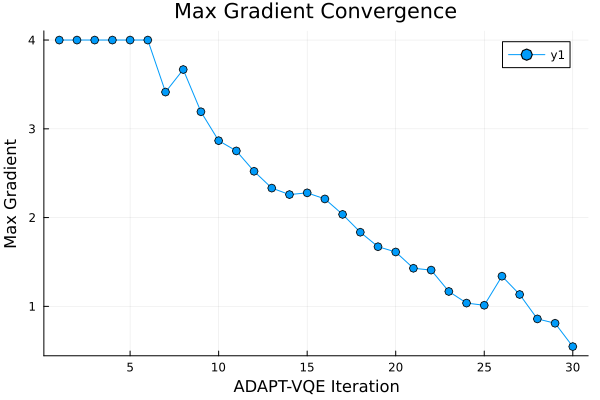

In [33]:
plot(max_grads, marker=:o)
plot!(title = "Max Gradient Convergence", xlabel = "ADAPT-VQE Iteration", ylabel = "Max Gradient")

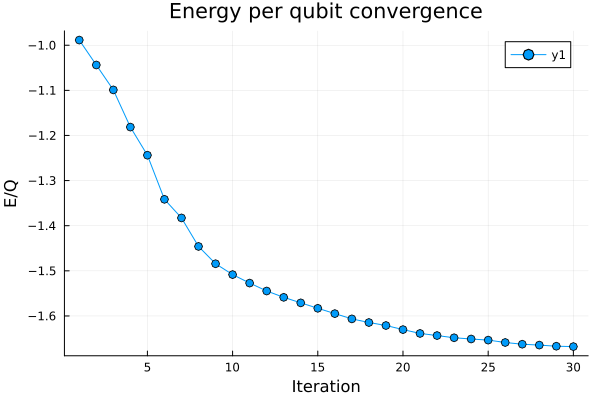

In [34]:
plot(opt_energy_gd, marker=:o)
display(plot!(title = "Energy per qubit convergence", xlabel = "Iteration", ylabel = "E/Q"))

In [35]:
println("Final energy", opt_energy_gd[end]*scaled_nq) # -1.616 is ED for 4 qubits, -1.54230900265439 for 5 qubits.

Final energy-25.01892245171569


This goes below the gs energy. But evaluate this with a higher truncation:

In [36]:
max_freq = 100
max_weight = 4
fulllossfunction(thetas, circuit, scaled_nq; max_freq=max_freq, max_weight=max_weight)

-25.005500841343977

### Comparison plot of weight truncations

In [37]:
# check the scaled pool generation
tile_nq = 3
scaled_nq = 15


tile_full_bit_pool = generate_full_bit_pool(tile_nq)
topo_tile = bricklayertopology(tile_nq;periodic=false)
tile_hamiltonian = heisenberg_hamiltonian(tile_nq, topo_tile)

scaled_pool = scaled_pool_generation(tile_nq, scaled_nq, tile_hamiltonian, tile_full_bit_pool; num_runs=15, run_iters=10, conv_tol=1e-2, verbose=false) 
# need approx. 15 runs to hit the 12 different operators 
# convert scaled pool to PauliStrings for printing
topo_scaled = bricklayertopology(scaled_nq;periodic=false)
scaled_hamiltonian = heisenberg_hamiltonian(scaled_nq, topo_scaled)
# truncations

max_freq = 15
max_weights = [2,3,4,5]
max_grads_all = Dict{Int, Vector{Float64}}()
opt_energy_all = Dict{Int, Vector{Float64}}()
for max_weight in max_weights
    println("=== Running adaptVQE with max_weight = $max_weight ===")
     circuit, thetas, chosen_ops, opt_energy_gd, max_grads = adaptVQE_loop(scaled_nq, scaled_hamiltonian, scaled_pool;theta_init = rand(Uniform(-pi,pi)), max_iters=40, conv_tol=1e-2, max_freq=max_freq, max_weight=max_weight, refresh_grad_tape=10, verbose=false
    );
    max_grads_all[max_weight] = max_grads
    opt_energy_all[max_weight] = opt_energy_gd
end

Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Convergence achieved with max gradient < 0.01
Chosen operators from tile ADAPT-VQE: 12
=== Running adaptVQE with max_weight = 2 ===
=== Running adaptVQE with max_weight = 3 ===
=== Running adaptVQE with max_weight = 4 ===
=== Running adaptVQE with max_weight = 5 ===


In [38]:
exact_energy_per_qubit = -25.667/nq
plot(max_weights, [opt_energy_all[w] for w in max_weights], label="Optimal Energy", marker=:o)
#plot!([1,maximum(max_weights)], [exact_energy_per_qubit, exact_energy_per_qubit], label="Exact Energy", linestyle=:dash, color=:black)
plot!(title = "Energy per qubit convergence for different max_weight", xlabel = "ADAPT-VQE Iteration", ylabel = "E/Q")

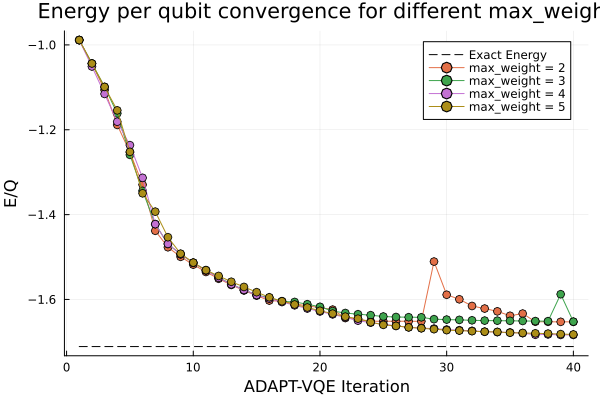

In [39]:
exact_energy_per_qubit = -25.667/scaled_nq
# Create an empty plot to hold the results
p = plot(title = "Energy per qubit convergence for different max_weight", 
         xlabel = "ADAPT-VQE Iteration", 
         ylabel = "E/Q")
plot!([1,length(opt_energy_all[max_weights[1]])], [exact_energy_per_qubit, exact_energy_per_qubit], label="Exact Energy", linestyle=:dash, color=:black)
# Loop through each max_weight and add its energy curve to the plot
for w in max_weights
    plot!(p, opt_energy_all[w], label="max_weight = $w", marker=:o)
end

# Display the final plot
display(p)

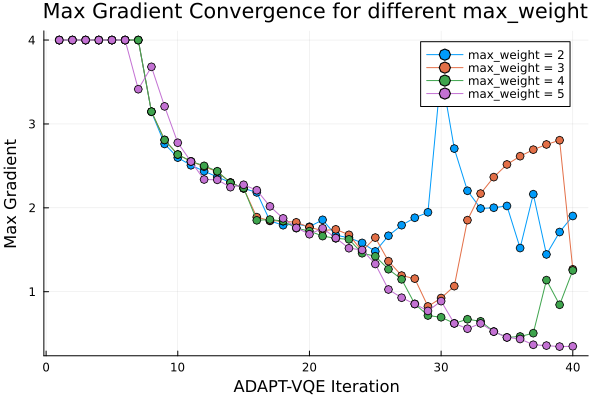

In [40]:
# gradients comparison plot
p2 = plot(title = "Max Gradient Convergence for different max_weight", 
         xlabel = "ADAPT-VQE Iteration", 
         ylabel = "Max Gradient")
for w in max_weights
    plot!(p2, max_grads_all[w], label="max_weight = $w", marker=:o)
end

# Display the final plot
display(p2) 